In [11]:
# Imports
import json
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import random

pd.options.display.max_columns = 200

In [12]:
# Small helper to load many TomTom JSONs (robust, but simple)
import re

def load_tomtom_jsons(region: str, data_root: Path = Path('..') / 'data' / 'tomtom') -> pd.DataFrame:
    folder = data_root / region
    if not folder.exists():
        raise FileNotFoundError(f'Folder not found: {folder}')
    files = sorted(glob.glob(str(folder / '*.json')))
    if not files:
        raise FileNotFoundError(f'No JSON files found in {folder}')
    rows = []
    for fp in files:
        try:
            j = json.load(open(fp, 'r', encoding='utf-8'))
        except Exception:
            continue

        # parse timestamp from filename if present
        file_ts = None
        try:
            stem = Path(fp).stem
            m = re.search(r'(\d{8}T\d{6}Z)', stem)
            if m:
                file_ts = pd.to_datetime(m.group(1), format='%Y%m%dT%H%M%SZ', utc=True, errors='coerce')
        except Exception:
            file_ts = None

        if isinstance(j, dict):
            candidates = None
            for k in ('records','items','features','results'):
                if k in j and isinstance(j[k], list):
                    candidates = j[k]
                    break
            if candidates is None:
                candidates = [j]
        elif isinstance(j, list):
            candidates = j
        else:
            candidates = []

        # Skip files that contain mainly API error messages and no traffic fields
        try:
            n = len(candidates)
            n_error = 0
            n_useful = 0
            for rec in candidates:
                if isinstance(rec, dict):
                    if any(k in rec for k in ('currentSpeed','speed','travelTime','freeFlowSpeed','confidence','level')):
                        n_useful += 1
                    if 'error' in rec:
                        n_error += 1
                    else:
                        for v in rec.values():
                            try:
                                vs = str(v).lower()
                                if 'forbidden' in vs or 'client error' in vs or '403' in vs or 'error' in vs or 'http' in vs:
                                    n_error += 1
                                    break
                            except Exception:
                                continue
                else:
                    s = str(rec).lower()
                    if 'forbidden' in s or 'client error' in s or '403' in s or 'error' in s or 'http' in s:
                        n_error += 1
            if n_useful == 0 and n > 0 and (n_error / n) > 0.4:
                continue
        except Exception:
            pass

        for rec in candidates:
            if isinstance(rec, dict):
                rec_copy = dict(rec)
                rec_copy['__file'] = fp
                rec_copy['__file_ts'] = file_ts
                rows.append(rec_copy)
            else:
                rows.append({'value': rec, '__file': fp, '__file_ts': file_ts})
    if not rows:
        return pd.DataFrame()
    df = pd.json_normalize(rows)

    # Prefer explicit time-like columns; convert to datetime safely
    # Note: avoid interpreting numeric duration fields (e.g., 'travelTime') as timestamps
    time_cols = [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower() or c.lower().endswith('timestamp')]
    ts_col = None
    for c in time_cols:
        try:
            s = pd.to_datetime(df[c], utc=True, errors='coerce')
            # guard: accept this column only if a reasonable number of parsed values
            # fall into a plausible year range (e.g., 2000-2100). This prevents fields
            # like 'travelTime' (small integers) becoming 1970-01-01 when coerced.
            if s.notna().any():
                try:
                    good = s.dt.year.between(2000, 2100).sum()
                except Exception:
                    good = 0
                threshold = max(1, int(0.01 * len(s)))
                if good >= threshold:
                    ts_col = c
                    df[c] = s
                    df['_ts'] = df[c]
                    break
        except Exception:
            continue

    # if no explicit _ts, use file timestamp
    if ('_ts' not in df.columns or df['_ts'].isna().all()) and '__file_ts' in df.columns:
        try:
            df['_ts'] = pd.to_datetime(df['__file_ts'], utc=True, errors='coerce')
        except Exception:
            df['_ts'] = pd.NaT

    # coerce common numeric fields
    for nm in ('currentSpeed','freeFlowSpeed','travelTime','speed'):
        if nm in df.columns:
            df[nm] = pd.to_numeric(df[nm], errors='coerce')
    return df


In [13]:
# Feature preparation: create _ts, rounded lat/lon and _pkey, target_speed, and simple lag/time features
def prepare_features(df: pd.DataFrame, timestamp_col_candidates=None) -> pd.DataFrame:
    df = df.copy()

    # Ensure any existing _ts is datetime
    if '_ts' in df.columns:
        try:
            df['_ts'] = pd.to_datetime(df['_ts'], utc=True, errors='coerce')
        except Exception:
            df['_ts'] = pd.NaT

    # Try to detect timestamp-like columns but guard against numeric duration fields
    if df.get('_ts').isna().all():
        ts_cols = timestamp_col_candidates or [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower() or c.lower()=='timestamp']
        for c in ts_cols:
            if c in df.columns:
                try:
                    cand = pd.to_datetime(df[c], utc=True, errors='coerce')
                    if cand.notna().any():
                        try:
                            good = cand.dt.year.between(2000, 2100).sum()
                        except Exception:
                            good = 0
                        threshold = max(1, int(0.01 * len(cand)))
                        if good >= threshold:
                            df['_ts'] = cand
                            break
                except Exception:
                    continue

    # If still missing, try filename timestamp column '__file_ts'
    if df.get('_ts').isna().all() and '__file_ts' in df.columns:
        try:
            df['_ts'] = pd.to_datetime(df['__file_ts'], utc=True, errors='coerce')
        except Exception:
            df['_ts'] = pd.NaT

    # As last resort create a dummy increasing time index starting in 2000 to avoid epoch/1970
    if df.get('_ts').isna().all():
        df['_ts'] = pd.date_range('2000-01-01', periods=len(df), freq='T', tz='UTC')

    # time features
    df['_hour'] = df['_ts'].dt.hour
    df['_dow'] = df['_ts'].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['_hour'] / 24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['_hour'] / 24.0)

    # spatial grouping: round lat/lon if available to group nearby samples
    lat_cols = [c for c in df.columns if c.lower().endswith('lat') or c.lower().startswith('lat')]
    lon_cols = [c for c in df.columns if c.lower().endswith('lon') or c.lower().startswith('lon')]
    if lat_cols and lon_cols:
        latc = lat_cols[0]; lonc = lon_cols[0]
        df['_plat'] = pd.to_numeric(df[latc], errors='coerce').round(5)
        df['_plon'] = pd.to_numeric(df[lonc], errors='coerce').round(5)
        df['_pkey'] = df['_plat'].astype(str) + '_' + df['_plon'].astype(str)
    else:
        df['_pkey'] = 'no_spatial'

    # target: prefer currentSpeed, fallback to speed or travelTime/length if available
    if 'currentSpeed' in df.columns:
        df['target_speed'] = pd.to_numeric(df['currentSpeed'], errors='coerce')
    elif 'speed' in df.columns:
        df['target_speed'] = pd.to_numeric(df['speed'], errors='coerce')
    elif 'travelTime' in df.columns and 'length' in df.columns:
        df['target_speed'] = pd.to_numeric(df['length'], errors='coerce') / pd.to_numeric(df['travelTime'], errors='coerce') * 3.6
    else:
        df['target_speed'] = np.nan

    # sort and create simple lag features per pkey
    df = df.sort_values('_ts')
    df['lag1'] = df.groupby('_pkey')['target_speed'].shift(1)
    df['lag2'] = df.groupby('_pkey')['target_speed'].shift(2)
    df['rolling_mean_3'] = df.groupby('_pkey')['target_speed'].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)

    # drop rows without target
    df = df[~df['target_speed'].isna()]

    return df


In [14]:
# Configuration: region folder name (adjust if needed)
region = 'eindhoven'
data_root = Path('..') / 'data' / 'tomtom'
print('Region:', region, 'data_root:', data_root)
# load historical data
try:
    hist = load_tomtom_jsons(region, data_root=data_root)
    print('Loaded historical rows:', len(hist))
except Exception as e:
    print('Could not load historical JSONs:', e); hist = pd.DataFrame()
# prepare features
if not hist.empty:
    df_feat = prepare_features(hist)
    print('Prepared features rows:', len(df_feat))
else:
    df_feat = pd.DataFrame()

Region: eindhoven data_root: ..\data\tomtom
Loaded historical rows: 19266
Prepared features rows: 19265


In [15]:
# Reverse-geocode representative coordinates per `_pkey` (cached)
# This cell will build a mapping `_pkey` -> `rev_name` using geopy/Nominatim.
# It caches responses to `geocode_cache.json` so repeated runs don't re-query the service.
# If `geopy` is not installed, the cell prints instructions to install it and falls back to existing name columns.

from pathlib import Path
import json

cache_fp = Path('geocode_cache.json')

try:
    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter
except Exception:
    print('geopy not installed. To enable reverse geocoding, run:')
    print('    pip install geopy')
    print('Falling back to existing name columns (no reverse geocode).')
    _rev_map = {}
else:
    # load cache if present
    if cache_fp.exists():
        try:
            with cache_fp.open('r', encoding='utf-8') as fh:
                _rev_map = json.load(fh)
        except Exception:
            _rev_map = {}
    else:
        _rev_map = {}

    # choose representative lat/lon per _pkey
    if '_pkey' not in df_feat.columns:
        print('No `_pkey` in df_feat; run prepare_features first.')
    else:
        # determine coordinate columns to use
        lat_col = '_plat' if '_plat' in df_feat.columns else None
        lon_col = '_plon' if '_plon' in df_feat.columns else None
        if lat_col is None or lon_col is None:
            # try generic lat/lon names
            lat_candidates = [c for c in df_feat.columns if c.lower().endswith('lat') or c.lower().startswith('lat')]
            lon_candidates = [c for c in df_feat.columns if c.lower().endswith('lon') or c.lower().startswith('lon')]
            lat_col = lat_candidates[0] if lat_candidates else None
            lon_col = lon_candidates[0] if lon_candidates else None

        if lat_col is None or lon_col is None:
            print('No latitude/longitude columns found in df_feat; cannot reverse-geocode.')
        else:
            # compute representative lat/lon per pkey (mean of values)
            coords = df_feat.groupby('_pkey').agg({lat_col: 'mean', lon_col: 'mean'})[[lat_col, lon_col]]
            coords = coords.dropna()
            print(f'Will reverse-geocode {len(coords)} unique _pkey values (cached entries will be reused).')

            geolocator = Nominatim(user_agent='dyson-traffic-revgeo-2025')
            # polite rate limiter: 1 request/s (adjust if you know your usage rules)
            geocode_rev = RateLimiter(geolocator.reverse, min_delay_seconds=1)

            updated = 0
            for pkey, row in coords.iterrows():
                if pkey in _rev_map:
                    continue
                lat = float(row[lat_col])
                lon = float(row[lon_col])
                try:
                    loc = geocode_rev((lat, lon), exactly_one=True, language='en')
                    if loc is None:
                        name = None
                    else:
                        addr = loc.raw.get('address', {}) if isinstance(loc.raw, dict) else {}
                        # prefer road/street fields, then neighbourhood, then display_name
                        name = addr.get('road') or addr.get('pedestrian') or addr.get('residential') or addr.get('neighbourhood') or addr.get('suburb') or loc.raw.get('display_name')
                        if isinstance(name, str):
                            name = name.strip()
                except Exception as e:
                    print(f'Reverse geocode failed for {pkey} ({lat},{lon}):', e)
                    name = None
                _rev_map[pkey] = name
                updated += 1
                # periodically flush cache
                if updated % 10 == 0:
                    try:
                        with cache_fp.open('w', encoding='utf-8') as fh:
                            json.dump(_rev_map, fh, ensure_ascii=False, indent=2)
                    except Exception:
                        pass

            # final save of cache
            try:
                with cache_fp.open('w', encoding='utf-8') as fh:
                    json.dump(_rev_map, fh, ensure_ascii=False, indent=2)
            except Exception as e:
                print('Could not save geocode cache:', e)

# attach reverse-geocoded name to df_feat if mapping exists
if '_rev_map' in globals() and _rev_map:
    df_feat['rev_name'] = df_feat['_pkey'].map(lambda x: _rev_map.get(x))
    print('Added `rev_name` to df_feat (may contain None for missing entries).')
    display(df_feat[['rev_name','_pkey']].drop_duplicates().head(20))
else:
    print('No reverse-geocode mapping available (either geopy missing or cache empty).')


Will reverse-geocode 464 unique _pkey values (cached entries will be reused).
Added `rev_name` to df_feat (may contain None for missing entries).


,rev_name,_pkey
0,Opwettenseweg,51.45996_5.52935
56,Aalbersepad,51.45618_5.51725
55,Aalbersepad,51.45627_5.51533
54,Aalbersepad,51.45628_5.51334
53,Aalbersepad,51.45608_5.51264
52,Aalbersepad,51.45585_5.51191
51,Aalbersepad,51.45551_5.51084
50,van Oldenbarneveltlaan,51.45512_5.50969
58,Geldropsedijk,51.4603_5.54242
49,Geldropsedijk,51.45653_5.54346


In [16]:
# Identify candidate street/name columns and show top-5 streets
if df_feat.empty:
    print('No prepared data (df_feat) is available.')
else:
    # prefer reverse-geocoded names if available
    cand_cols = []
    if 'rev_name' in df_feat.columns:
        cand_cols.append('rev_name')

    # find textual columns that look like street/name labels
    other = [c for c in df_feat.columns if any(k in c.lower() for k in ('road','street','name','label','address','display','freeform','roadname','streetname'))]
    other = [c for c in other if df_feat[c].dropna().map(lambda x: isinstance(x, str)).any()]
    for c in other:
        if c not in cand_cols:
            cand_cols.append(c)

    # If no explicit candidate found, fallback: pick short-string columns with reasonable uniqueness
    if not cand_cols:
        str_cols = [c for c in df_feat.columns if df_feat[c].dropna().map(lambda x: isinstance(x, str)).any()]
        def score_col(c):
            s = df_feat[c].dropna().astype(str)
            nunique = s.nunique()
            avg_len = s.map(len).mean() if len(s) > 0 else 0
            return (nunique, avg_len)
        scored = sorted(str_cols, key=score_col)
        cand_cols = scored[:3]

    print('Candidate name columns (in preference order):', cand_cols)
    if not cand_cols:
        print('No street/name columns detected.')
    else:
        # pick a preferred column (rev_name, road/street) or first candidate
        chosen_col = None
        for pref in ('rev_name','road','street'):
            for c in cand_cols:
                if pref in c.lower():
                    chosen_col = c; break
            if chosen_col: break
        if chosen_col is None: chosen_col = cand_cols[0]
        print('Using column for street names (initial):', chosen_col)

        # sanitize name values to remove API errors, URLs, and very long or non-alphabetic strings
        import re
        bad_pat = re.compile(r'(http|https|forbidden|client error|error|exception|for url|api\.|\b403\b|\b404\b|\b500\b)', flags=re.I)
        def valid_name(s: str) -> bool:
            if not isinstance(s, str):
                return False
            s2 = s.strip()
            if not s2:
                return False
            if len(s2) > 120:
                return False
            if bad_pat.search(s2):
                return False
            # require at least two alphabetic characters
            if sum(ch.isalpha() for ch in s2) < 2:
                return False
            return True

        # clean and filter names from chosen column
        names = df_feat[chosen_col].dropna().astype(str).map(lambda x: x.strip())
        names_clean = names.map(lambda x: x if valid_name(x) else None).dropna()

        # if no valid names found in chosen_col, try other candidate columns
        if names_clean.empty:
            found = False
            for c in cand_cols:
                if c == chosen_col:
                    continue
                names = df_feat[c].dropna().astype(str).map(lambda x: x.strip())
                names_clean = names.map(lambda x: x if valid_name(x) else None).dropna()
                if not names_clean.empty:
                    chosen_col = c
                    print('Falling back to column for street names:', chosen_col)
                    found = True
                    break
            if not found:
                print('No valid street/name values found across candidate columns.')
                _chosen_col = None
                _top5 = pd.DataFrame(columns=['street_name','count'])

        # build top-5 from cleaned names
        if not names_clean.empty:
            top5 = names_clean.value_counts().head(5).reset_index()
            top5.columns = ['street_name', 'count']
            display(top5)
            # store for next cell
            _chosen_col = chosen_col
            _top5 = top5


Candidate name columns (in preference order): ['rev_name']
Using column for street names (initial): rev_name


,street_name,count
0,Gijzenrooiseweg,1972
1,Rijksweg 67,1208
2,Gijzenrooi,1055
3,Collseweg,962
4,Genoenhuis,865


Choose a street by number:
1: Gijzenrooiseweg (1972 rows)
2: Rijksweg 67 (1208 rows)
3: Gijzenrooi (1055 rows)
4: Collseweg (962 rows)
5: Genoenhuis (865 rows)
Selected street: Gijzenrooiseweg
Representative _pkey: 51.42426_5.53636
Applying per-location bias (mean residual) -0.04 km/h


,_hour,pred_speed,actual_speed,pred_speed_adj
0,0,50.405124,NaN,50.363564
1,1,50.405124,NaN,50.363564
2,2,50.405124,NaN,50.363564
3,3,47.097727,47.000000,47.056167
4,4,50.405124,NaN,50.363564
5,5,46.950176,47.000000,46.908616
6,6,50.405124,NaN,50.363564
7,7,43.325283,43.000000,43.283724
8,8,47.030968,47.000000,46.989409
9,9,50.405124,NaN,50.363564


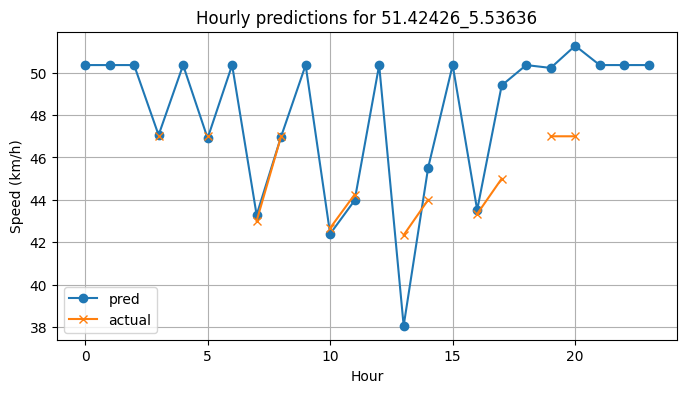

In [17]:
# Select one of the top-5 streets (by index) and show hourly predictions using the saved model
# This cell builds hourly feature vectors from historical rows for the selected _pkey and predicts per-hour.
if '_top5' not in globals() or _top5 is None or _top5.empty:
    print('Top-5 street list not available; run the cell first.')
else:
    # present options to the user
    print('Choose a street by number:')
    for i, r in _top5.reset_index(drop=True).iterrows():
        # use dict-style access to avoid attribute-method confusion
        print(f"{i+1}: {r['street_name']} ({int(r['count'])} rows)")
    s = input('Enter 1..' + str(len(_top5)) + ' (default=1): ').strip()
    if s == '': s = '1'
    try:
        idx = max(1, min(len(_top5), int(s))) - 1
        selected_name = _top5.reset_index(drop=True).loc[idx, 'street_name']
    except Exception as e:
        print('Invalid selection, defaulting to first:', e); selected_name = _top5.reset_index(drop=True).loc[0, 'street_name']
    print('Selected street:', selected_name)

    # determine which column we are matching on (prefer rev_name if present)
    match_col = _chosen_col if ('_chosen_col' in globals() and _chosen_col) else None
    if match_col is None and 'rev_name' in df_feat.columns:
        match_col = 'rev_name'
    if match_col is None:
        # fallback to first string column
        str_cols = [c for c in df_feat.columns if df_feat[c].dropna().map(lambda x: isinstance(x, str)).any()]
        match_col = str_cols[0] if str_cols else None

    if match_col is None:
        print('No textual column available to match selected name.'); raise SystemExit

    # find representative pkey rows
    rows = df_feat[df_feat[match_col].astype(str) == selected_name]
    if rows.empty or '_pkey' not in rows.columns:
        print('No _pkey available for selected street.')
    else:
        sel_pkey = rows['_pkey'].dropna().value_counts().idxmax()
        print('Representative _pkey:', sel_pkey)
        # load saved model and features
        model_fp = Path(f'model_{region}.joblib')
        if not model_fp.exists():
            print('Saved model not found:', model_fp); raise SystemExit
        mdata = joblib.load(model_fp)
        model = mdata.get('model')
        features = mdata.get('features') or []
        if model is None:
            print('Model missing in the saved joblib.'); raise SystemExit

        subset = df_feat[df_feat['_pkey'] == sel_pkey].copy()
        if subset.empty:
            print('No historical rows to score for', sel_pkey)
        else:
            # ensure _ts is datetime
            if '_ts' in subset.columns:
                subset['_ts'] = pd.to_datetime(subset['_ts'], utc=True, errors='coerce')
            else:
                subset['_ts'] = pd.NaT

            # prepare features per hour by averaging historical rows' feature columns
            if features:
                feat_cols = [f for f in features if f in subset.columns]
            else:
                # try sensible defaults first
                default_feats = ['hour_sin','hour_cos','_dow','lag1','lag2','rolling_mean_3']
                feat_cols = [f for f in default_feats if f in subset.columns]
                if not feat_cols:
                    # fallback: numeric columns excluding identifiers and target
                    feat_cols = [c for c in subset.select_dtypes(include=[np.number]).columns if c not in ('target_speed',)]

            if not feat_cols:
                print('No numeric features available to build hourly vectors. Showing raw historical means instead.')
                # build simple per-hour mean of target_speed and show as proxy
                subset['_hour'] = subset['_ts'].dt.hour
                hour_means = subset.groupby('_hour')['target_speed'].mean().reindex(range(24)).reset_index()
                hour_means.columns = ['_hour','actual_speed']
                display(hour_means)
                raise SystemExit

            # group by hour and compute mean feature vector
            subset['_hour'] = subset['_ts'].dt.hour
            hour_means = subset.groupby('_hour')[feat_cols].mean()
            # create full 0..23 index
            hours = pd.DataFrame(index=range(24))
            X_hours = hours.join(hour_means).reset_index().rename(columns={'index':'_hour'})
            # fill missing hours with overall mean (use Series so columns align)
            overall = subset[feat_cols].mean()
            try:
                X_hours[feat_cols] = X_hours[feat_cols].fillna(overall)
            except Exception:
                # final safe fallback: fill with column-wise values using loop
                for col in feat_cols:
                    if col in X_hours.columns:
                        X_hours[col] = X_hours[col].fillna(overall.get(col, np.nan))

            # predict
            try:
                Xpred = X_hours[feat_cols].fillna(-1)
                preds = model.predict(Xpred)
            except Exception as e:
                print('Prediction failed on hourly vectors:', e); preds = None

            if preds is not None:
                results = pd.DataFrame({'_hour': X_hours['_hour'], 'pred_speed': preds})
                # compute actual mean per hour if available
                actual = subset.groupby('_hour')['target_speed'].mean().reset_index().rename(columns={'target_speed':'actual_speed'})
                results = results.merge(actual, on='_hour', how='left')

                # If model didn't include location features, compute and apply bias correction from historical residuals
                loc_in_features = any(f in features for f in ('_plat','_plon','_pkey'))
                if not loc_in_features and 'target_speed' in subset.columns:
                    # compute historical residual mean
                    Xhist = subset.reindex(columns=feat_cols).fillna(-1)
                    try:
                        phist = model.predict(Xhist)
                        bias = (subset['target_speed'] - phist).mean()
                        print(f'Applying per-location bias (mean residual) {bias:.2f} km/h')
                        results['pred_speed_adj'] = results['pred_speed'] + bias
                        used_pred_col = 'pred_speed_adj'
                    except Exception as e:
                        print('Could not compute historical residuals for bias:', e)
                        used_pred_col = 'pred_speed'
                else:
                    used_pred_col = 'pred_speed'

                display(results)
                plt.figure(figsize=(8,4))
                plt.plot(results['_hour'], results[used_pred_col], marker='o', label='pred')
                if 'actual_speed' in results.columns:
                    plt.plot(results['_hour'], results['actual_speed'], marker='x', label='actual')
                plt.xlabel('Hour'); plt.ylabel('Speed (km/h)'); plt.title(f'Hourly predictions for {sel_pkey}')
                plt.grid(True); plt.legend(); plt.show()

                # save CSV for inspection
                out_fp = Path(f'test_predictions_{region}_{sel_pkey}.csv')
                # include lat/lon column names if present
                lat_col = 'lat' if 'lat' in subset.columns else ('_plat' if '_plat' in subset.columns else None)
                lon_col = 'lon' if 'lon' in subset.columns else ('_plon' if '_plon' in subset.columns else None)
                save_cols = []
                if lat_col: save_cols.append(lat_col)
                if lon_col: save_cols.append(lon_col)
                save_cols += ['_plat','_plon','_pkey','_ts','target_speed']
                save_df = subset[[c for c in save_cols if c in subset.columns]].copy()
                # attach predicted column per row by mapping hour
                save_map = results.set_index('_hour')[used_pred_col].to_dict()
                save_df['_hour'] = save_df['_ts'].dt.hour
                save_df['pred_speed_hourly'] = save_df['_hour'].map(save_map)
                # save_df.to_csv(out_fp, index=False)
                # print('Saved per-row test predictions to', out_fp)
